匹配AVHRR信息和轨迹信息

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cmaps
import cartopy.feature as cfeature
from datetime import datetime,timedelta
from matplotlib.offsetbox import AnchoredText#关于修改text位置的
from datetime import datetime,timedelta
import cv2
from pygac import get_reader_class
import ast
from tqdm import tqdm
import warnings
from sklearn.neighbors import BallTree
from shapely.geometry import Point, Polygon,LineString
from shapely.ops import nearest_points
import json
import shutil

d:\anaconda\envs\FRZ\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [40]:
def geodistance(lon1,lat1,lon2,lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) # 经纬度转换成弧度
    dlon=lon2-lon1
    dlat=lat2-lat1
    a=np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    distance=2*np.arcsin(np.sqrt(a))*6371*1000 # 地球平均半径，6371km
    distance=np.round(distance,3)
    return distance/1000
def xy2lonlat(chosed_lon,chosed_lat,x,y):
    #距离转经纬度
    #纬圈距离
    earth_radius = 6371.0
    lat_circum = np.cos(np.radians(chosed_lat))*2*np.pi*earth_radius
    d_lon = x/lat_circum*360
    d_lat = y/(2*np.pi*earth_radius)*360
    new_lon,new_lat = chosed_lon+d_lon,chosed_lat+d_lat
    return new_lon,new_lat
#将经纬度转换为极射投影,并求极坐标系中的最近距离和最近点，注意该最近距离指极坐标距离而非球面距离
def nearest_judge(chosed_lon,chosed_lat,border):
    #似乎只能一对一
    #1、计算平面上各点到极点的距离和夹角
    earth_radius = 6371.0
    r = (90-border[:,1])/90*earth_radius
    theta = np.radians(border[:,0])
    #2、将边界转换为x,y坐标，注意该坐标系以-90°为y轴负轴，相当于中心经度设置为-90
    x,y = np.cos(theta)*r,np.sin(theta)*r
    points_coords = np.concatenate([np.reshape(x,(-1,1)),np.reshape(y,(-1,1))],axis=1) 
    #将中心点转换为x,y
    r0 = (90-chosed_lat)/90*earth_radius
    theta0 = np.radians(chosed_lon)
    x0,y0 = np.cos(theta0)*r0,np.sin(theta0)*r0
    #3、计算最近点
    point = Point(x0,y0)
    Line_border = LineString(points_coords)
    #4、判断点是否在多边形内,这里判断是否在内要用polygon对象
    inside = point.within(Polygon(points_coords))
    nearest_point,_= nearest_points(Line_border, point)
    near_x,near_y = nearest_point.coords[0]
    min_dis = np.sqrt((near_x-x0)**2+(near_y-y0)**2)
    #print(inside,min_dis)
    near_r = np.sqrt(near_x**2+near_y**2)
    #反演回经纬度
    near_lon = np.rad2deg(np.arctan2(near_y ,near_x))
    near_lat = (1-near_r/earth_radius)*90
    return near_lon,near_lat,inside,min_dis
#计算点之间距离
def deal_distance(line):
    distance = [0]
    for i in range(len(line)-1):
        distance.append(np.round(geodistance(line[i][0],line[i][1],line[i+1][0],line[i+1][1]),3))
    return distance

In [46]:
AVHRR_info = pd.read_excel(r"D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\AVHRR_infos_2008_11.xlsx")
AVHRR_info['border'] = AVHRR_info['border'].apply(lambda x :np.array(ast.literal_eval(x)).T)
ERA5_tracks = pd.read_excel(r"D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\track_2008_11.xlsx",usecols=['time','path_index','lon','lat','peak_value'])
ERA5_tracks

,time,path_index,lon,lat,peak_value
0,2008-11-01 00:00:00,0,-18.25,72.25,1.576954
1,2008-11-01 00:00:00,1,-0.50,77.00,1.815238
2,2008-11-01 00:00:00,2,-30.25,66.00,2.566751
3,2008-11-01 00:00:00,3,27.00,64.50,1.591397
4,2008-11-01 00:00:00,4,-9.50,72.50,1.675173
...,...,...,...,...,...
10149,2008-11-30 23:00:00,938,29.25,66.75,1.307585
10150,2008-11-30 22:00:00,939,46.25,60.75,1.313290
10151,2008-11-30 23:00:00,939,46.75,60.50,1.320050
10152,2008-11-30 23:00:00,940,-15.75,65.75,1.524033


In [47]:
#选择六个时次以上的轨迹
life_count = ERA5_tracks.value_counts('path_index').reset_index()
ERA5_tracks = ERA5_tracks.loc[ERA5_tracks.path_index.isin(life_count.loc[life_count['count']>5,'path_index'])].copy()
ERA5_tracks['split_path_index'] = ERA5_tracks['path_index'].values
#分割距离较长的气旋路径
threshold = 200#KM,当距离超过200KM时认为路径断开，这种情况常常因为涡旋区域的中心发生了改变，这样处理认为改变后的涡旋为新生涡旋，原涡旋为衰退涡旋
path_reindex = ERA5_tracks.path_index.max()+1
new_track_record = []
for path_index in tqdm(ERA5_tracks.path_index.unique()):
    pick_track = ERA5_tracks.loc[ERA5_tracks.path_index==path_index]
    #计算轨迹中点与点之间的距离
    dis_interval = np.array(deal_distance(pick_track.loc[:,['lon','lat']].values))
    #找到分割点
    track_seg = np.concatenate((np.array([0]),np.where(dis_interval>threshold)[0],np.array([len(pick_track)])), axis=0)
    #分割不同部分
    for i in range(len(track_seg)-1):
        #第一段按照原来的Path_index
        temp_track = pick_track[track_seg[i]:track_seg[i+1]].copy()
        if (i>0)&(temp_track.iloc[0].peak_value<2):
            temp_track.split_path_index= path_reindex
            path_reindex += 1
        new_track_record.append(temp_track)      
#去除强度分割得到的中间path_index
ERA5_tracks = pd.concat(new_track_record,axis=0)
ERA5_tracks 

100%|██████████| 440/440 [00:00<00:00, 946.31it/s] 


,time,path_index,lon,lat,peak_value,split_path_index
15,2008-11-01 00:00:00,7,43.75,65.75,1.768080,7
16,2008-11-01 01:00:00,7,47.50,66.00,1.633301,7
17,2008-11-01 02:00:00,7,48.75,66.00,1.611044,7
18,2008-11-01 03:00:00,7,39.25,65.50,1.612249,935
19,2008-11-01 04:00:00,7,39.50,65.50,1.661914,935
...,...,...,...,...,...,...
10133,2008-11-30 19:00:00,934,-19.50,66.50,1.855620,934
10134,2008-11-30 20:00:00,934,-20.25,65.75,1.747692,934
10135,2008-11-30 21:00:00,934,-20.00,65.50,1.689195,934
10136,2008-11-30 22:00:00,934,-19.75,65.25,1.537685,934


In [21]:
AVHRR_info#mean_time:所有50°N以上的平均扫描时间,border:扫描图像的边界四点

,Unnamed: 0,filename,dataset_type,satellite_name,start_time,end_time,filepath,tle_name,year_month,border,mean_time
0,0,NSS.GHRR.NM.D08306.S0013.E0142.B3302829.WI,GHRR,NOAA-17,2008-11-01 00:13:00,2008-11-01 01:42:00,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08306.S0013.E0142.B...,NOAA-17_tle.txt,2008-11-01,"[[-27.66072683885269, 55.25605275439017], [-67...",2008-11-01 00:18:00
1,1,NSS.GHRR.NK.D08306.S0039.E0224.B5442930.GC,GHRR,NOAA-15,2008-11-01 00:39:00,2008-11-01 02:24:00,Z:\NOAA_AVHRR\NSS.GHRR.NK.D08306.S0039.E0224.B...,NOAA-15_tle.txt,2008-11-01,"[[-55.889184064012284, 85.42360983205805], [15...",2008-11-01 01:04:00
2,2,NSS.GHRR.NN.D08306.S0057.E0251.B1777778.SV,GHRR,NOAA-18,2008-11-01 00:57:00,2008-11-01 02:51:00,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08306.S0057.E0251.B...,NOAA-18_tle.txt,2008-11-01,"[[-105.29832618105682, 84.60716567687085], [10...",2008-11-01 01:21:00
3,3,NSS.GHRR.NL.D08306.S0135.E0321.B4181011.GC,GHRR,NOAA-16,2008-11-01 01:35:00,2008-11-01 03:21:00,Z:\NOAA_AVHRR\NSS.GHRR.NL.D08306.S0135.E0321.B...,NOAA-16_tle.txt,2008-11-01,"[[-64.99261630859377, 85.23978322277314], [144...",2008-11-01 02:00:00
4,4,NSS.GHRR.NM.D08306.S0137.E0323.B3302830.WI,GHRR,NOAA-17,2008-11-01 01:37:00,2008-11-01 03:23:00,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08306.S0137.E0323.B...,NOAA-17_tle.txt,2008-11-01,"[[-47.38378359658267, 74.70564711723532], [-11...",2008-11-01 02:02:00
...,...,...,...,...,...,...,...,...,...,...,...
2291,2291,NSS.GHRR.M2.D08335.S2155.E2337.B1098586.SV,GHRR,Metop-A,2008-11-30 21:55:00,2008-11-30 23:37:00,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08335.S2155.E2337.B...,Metop-A_tle.txt,2008-11-01,"[[-19.355283862879425, 50.03218853644102], [-5...",2008-11-30 23:14:00
2292,2292,NSS.GHRR.NL.D08335.S2301.E0054.B4223233.GC,GHRR,NOAA-16,2008-11-30 23:01:00,2008-12-01 00:54:00,Z:\NOAA_AVHRR\NSS.GHRR.NL.D08335.S2301.E0054.B...,NOAA-16_tle.txt,2008-11-01,"[[-44.17775211677569, 84.27574360786984], [-17...",2008-11-30 23:21:00
2293,2293,NSS.GHRR.NN.D08335.S2301.E0049.B1819900.GC,GHRR,NOAA-18,2008-11-30 23:01:00,2008-12-01 00:49:00,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08335.S2301.E0049.B...,NOAA-18_tle.txt,2008-11-01,"[[-77.00734183686967, 84.71099221502931], [129...",2008-11-30 23:26:00
2294,2294,NSS.GHRR.NM.D08335.S2239.E0022.B3345455.GC,GHRR,NOAA-17,2008-11-30 22:39:00,2008-12-01 00:22:00,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08335.S2239.E0022.B...,NOAA-17_tle.txt,2008-11-01,"[[-1.8841533997657969, 66.95727514794018], [-5...",2008-11-30 23:28:00


为每个路径的开始和结束添加额外的两个点来观察演变

In [31]:
new = []
for idx in tqdm(ERA5_tracks.path_index.unique()):
    single_track =ERA5_tracks.loc[ERA5_tracks.path_index==idx].copy().reset_index(drop=True)
    start = pd.DataFrame(single_track.iloc[0]).T
    end = pd.DataFrame(single_track.iloc[-1]).T
    end_index = len(single_track)-1
    start_time,end_time = single_track.loc[0,'time'],single_track.loc[end_index,'time']
    cilent_columns = ['peak_value']
    start.loc[:,cilent_columns] = np.nan
    end.loc[:,cilent_columns] = np.nan
    #增添两个点
    start1,start2 = start.copy(),start.copy()
    end1,end2 = end.copy(),end.copy()
    start1.loc[0,'time'] = start_time-timedelta(hours=1)
    start2.loc[0,'time'] = start_time-timedelta(hours=2)
    start1.loc[0,'relative'] = -1000
    start2.loc[0,'relative'] = -999
    end1.loc[end_index,'time'] = end_time+timedelta(hours=1)
    end2.loc[end_index,'time'] = end_time+timedelta(hours=2)
    end1.loc[end_index,'relative'] = 999
    end2.loc[end_index,'relative'] = 1000
    new.append(pd.concat([start2,start1,single_track,end1,end2],axis=0))
new_all_tracks = pd.concat(new,axis=0)
ERA5_tracks = new_all_tracks.reset_index(drop=True)
ERA5_tracks['point_index'] = np.arange(len(ERA5_tracks))
ERA5_tracks

100%|██████████| 942/942 [00:02<00:00, 343.85it/s]


,time,path_index,lon,lat,peak_value,relative,point_index
0,2008-10-31 20:00:00,0,-18.25,72.25,NaN,-999,0
1,2008-10-31 21:00:00,0,-18.25,72.25,NaN,-1000,1
2,2008-10-31 22:00:00,0,-18.25,72.25,NaN,-999.0,2
3,2008-10-31 23:00:00,0,-18.25,72.25,NaN,-1000.0,3
4,2008-11-01 00:00:00,0,-18.25,72.25,1.576954,NaN,4
...,...,...,...,...,...,...,...
17685,2008-11-30 23:00:00,941,42.25,66.5,1.28706,NaN,17685
17686,2008-12-01 00:00:00,941,42.25,66.5,NaN,999.0,17686
17687,2008-12-01 01:00:00,941,42.25,66.5,NaN,1000.0,17687
17688,2008-12-01 02:00:00,941,42.25,66.5,NaN,999,17688


,index,time,path_index,lon,lat,peak_value,relative
0,0,2008-10-31 22:00:00,0,-18.25,72.25,NaN,-999.0
0,0,2008-10-31 23:00:00,0,-18.25,72.25,NaN,-1000.0
0,0,2008-11-01 00:00:00,0,-18.25,72.25,1.576954,NaN
0,0,2008-11-01 01:00:00,0,-18.25,72.25,NaN,999.0
0,0,2008-11-01 02:00:00,0,-18.25,72.25,NaN,1000.0
...,...,...,...,...,...,...,...
0,10153,2008-11-30 21:00:00,941,42.25,66.5,NaN,-999.0
0,10153,2008-11-30 22:00:00,941,42.25,66.5,NaN,-1000.0
0,10153,2008-11-30 23:00:00,941,42.25,66.5,1.28706,NaN
0,10153,2008-12-01 00:00:00,941,42.25,66.5,NaN,999.0


In [6]:
tle_dir = r'D:\Desktop\NOAA_TLE'
#波段4：红外
def read_AVHRR(filepath,tle_name):
    reader_cls = get_reader_class(filepath)
    reader = reader_cls(tle_dir=tle_dir, tle_name=tle_name)
    reader.read(filepath)
    channels = reader.get_calibrated_channels()
    lons, lats = reader.get_lonlat()
    IR = channels
    #异常扫描线去除-------------------------------------------------------------------------------
    masked_scanlines = np.isnan(IR[:,:,4]).sum(axis=1)>0
    IR = IR[~masked_scanlines]
    lons = lons[~masked_scanlines,:]
    lats = lats[~masked_scanlines,:]
    return IR,lons,lats

In [23]:
#匹配AVHRR
def judge_match(candidate_track,AVHRR_info):
    chosed_time,chosed_lon,chosed_lat = candidate_track.time,candidate_track.lon,candidate_track.lat
    #筛选在该小时内的所有AVHRR文件
    candidate_urlinfo = AVHRR_info.loc[np.logical_and(AVHRR_info.mean_time<chosed_time+timedelta(seconds=60*60),
                                        AVHRR_info.mean_time>chosed_time)]
    result = []
    for i in range(len(candidate_urlinfo)):
        basic_info =  candidate_urlinfo.iloc[i][['filepath','tle_name','border','dataset_type','satellite_name','mean_time']].copy()
        near_lon,near_lat,inside,min_dis = nearest_judge(chosed_lon,chosed_lat,basic_info.border)
        basic_info.border = json.dumps(basic_info.border.tolist())
        #在图像内部并且边缘距离大于400
        if inside&(min_dis>250):
            temp_track = pd.DataFrame(candidate_track).T
            temp_track[['filepath','tle_name','border','dataset_type','satellite_name','mean_time']] = basic_info.values
            result.append(temp_track)
    return result


粗匹配

In [25]:
result  = []
for idx in tqdm(range(len(ERA5_tracks)),desc='匹配中',position=1):
    candidate_track = ERA5_tracks.iloc[idx]
    temp = judge_match(ERA5_tracks.iloc[idx],AVHRR_info)
    result += temp
result = pd.concat(result,axis=0)
result

匹配中: 100%|██████████| 10154/10154 [00:27<00:00, 374.65it/s]


,point_index,time,path_index,lon,lat,peak_value,filepath,tle_name,border,dataset_type,satellite_name,mean_time
8,8,2008-11-01 01:00:00,5,-5.25,82.0,1.590117,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08306.S0057.E0251.B...,NOAA-18_tle.txt,"[[-105.29832618105682, 84.60716567687085], [10...",GHRR,NOAA-18,2008-11-01 01:21:00
10,10,2008-11-01 03:00:00,5,-5.5,81.5,1.63308,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08306.S0246.E0433.B...,NOAA-18_tle.txt,"[[-130.98462437894077, 84.6014362476965], [75....",GHRR,NOAA-18,2008-11-01 03:03:00
11,11,2008-11-01 00:00:00,6,-34.25,66.0,2.379121,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08306.S0013.E0142.B...,NOAA-17_tle.txt,"[[-27.66072683885269, 55.25605275439017], [-67...",GHRR,NOAA-17,2008-11-01 00:18:00
16,16,2008-11-01 01:00:00,7,47.5,66.0,1.633301,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08306.S0057.E0251.B...,NOAA-18_tle.txt,"[[-105.29832618105682, 84.60716567687085], [10...",GHRR,NOAA-18,2008-11-01 01:21:00
17,17,2008-11-01 02:00:00,7,48.75,66.0,1.611044,Z:\NOAA_AVHRR\NSS.GHRR.NK.D08306.S0219.E0407.B...,NOAA-15_tle.txt,"[[-81.35174214691182, 85.41854356156105], [129...",GHRR,NOAA-15,2008-11-01 02:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...
10142,10142,2008-11-30 23:00:00,935,-41.75,54.5,1.579933,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08335.S2155.E2337.B...,Metop-A_tle.txt,"[[-19.355283862879425, 50.03218853644102], [-5...",GHRR,Metop-A,2008-11-30 23:14:00
10147,10147,2008-11-30 23:00:00,937,31.5,70.0,1.440464,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08335.S2301.E0049.B...,NOAA-18_tle.txt,"[[-77.00734183686967, 84.71099221502931], [129...",GHRR,NOAA-18,2008-11-30 23:26:00
10149,10149,2008-11-30 23:00:00,938,29.25,66.75,1.307585,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08335.S2301.E0049.B...,NOAA-18_tle.txt,"[[-77.00734183686967, 84.71099221502931], [129...",GHRR,NOAA-18,2008-11-30 23:26:00
10151,10151,2008-11-30 23:00:00,939,46.75,60.5,1.32005,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08335.S2301.E0049.B...,NOAA-18_tle.txt,"[[-77.00734183686967, 84.71099221502931], [129...",GHRR,NOAA-18,2008-11-30 23:26:00


根据涡度位置重匹配

In [ ]:
def calculate_meantime(filepath,tle_name,central_lon,central_lat):
    #计算中心点50KM内的平均扫描时间
    tle_dir = r'Z:\NOAA_TLE'
    reader_cls = get_reader_class(filepath)
    reader = reader_cls(tle_dir=tle_dir, tle_name=tle_name)
    reader.read(filepath)
    times = reader.get_times()
    lons, lats = reader.get_lonlat()
    dis_array = geodistance(central_lon,central_lat,lons,lats)
    scantime150 = times[(dis_array<50).sum(axis=1)>0]
    #去除空值
    scantime150 = scantime150[~np.isnan(scantime150)]
    if len(scantime150)==0:
        return np.nan
    meantime = pd.Series(scantime150).mean()
    #规整到分钟
    return pd.to_datetime( meantime.strftime('%Y%m%d_%H%M'),format='%Y%m%d_%H%M')

In [ ]:
#行：扫描线,有时几个扫描线数据损坏为nan值
def urlinfo2fig(ax,IR,AV_lons,AV_lats,central_lon,central_lat,border,find_lon,find_lat):
    #central_lon,central_lat = np.nanmean(AV_lons),np.nanmean(AV_lats)
    left,right,upper,down = int(central_lon-30),int(central_lon+30),int(central_lat+30),int(central_lat-20)
    
    extent = [left,right,upper,down]
    #ax.add_feature(cfeature.COASTLINE.with_scale('110m'))
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND.with_scale('10m'), edgecolor='black')
    gl = ax.gridlines(
        xlocs=np.arange(left, right, (right-left)//5), ylocs=np.arange(down, upper,(upper-down)//4),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=1, linestyle='--', color='gray')
    gl.right_labels,gl.top_labels,gl.rotate_labels =False, False, False
    ax.scatter(central_lon,central_lat, marker = 'x', s=100, c='red',label='center',transform =ccrs.Geodetic())
    ax.scatter(find_lon,find_lat, marker = 'x', s=100, c='blue',label='center',transform =ccrs.Geodetic())
    C1=ax.pcolormesh(AV_lons,AV_lats,IR,cmap = 'gray_r', transform =ccrs.PlateCarree(),zorder=0)#画填色图
    ax.plot(border[:,0],border[:,1],transform =ccrs.Geodetic(),linewidth=2,color='yellow',linestyle='-',zorder=0,label='whole border')
    ax.plot([find_lon,central_lon],[find_lat,central_lat],transform =ccrs.Geodetic(),linewidth=2,color='blue',linestyle='--',zorder=0)
    #ax.set_title('AVHRR(10.4um)',fontweight="bold",fontsize=30,loc='left')
    #ax.legend()
    return C1

In [ ]:
#行：扫描线,有时几个扫描线数据损坏为nan值
def nor_urlinfo2fig(ax,IR,AV_lons,AV_lats,central_lon,central_lat,border):
    #central_lon,central_lat = np.nanmean(AV_lons),np.nanmean(AV_lats)
    left,right,upper,down = int(central_lon-30),int(central_lon+30),int(central_lat+30),int(central_lat-20)
    
    extent = [left,right,upper,down]
    #ax.add_feature(cfeature.COASTLINE.with_scale('110m'))
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND.with_scale('10m'), edgecolor='black')
    gl = ax.gridlines(
        xlocs=np.arange(left, right, (right-left)//5), ylocs=np.arange(down, upper,(upper-down)//4),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=1, linestyle='--', color='gray')
    gl.right_labels,gl.top_labels,gl.rotate_labels =False, False, False
    ax.scatter(central_lon,central_lat, marker = 'x', s=100, c='red',label='center',transform =ccrs.Geodetic())
    C1=ax.pcolormesh(AV_lons,AV_lats,IR,cmap = 'gray_r', transform =ccrs.PlateCarree(),zorder=0)#画填色图
    ax.plot(border[:,0],border[:,1],transform =ccrs.Geodetic(),linewidth=2,color='yellow',linestyle='-',zorder=0,label='whole border')
    #ax.set_title('AVHRR(10.4um)',fontweight="bold",fontsize=30,loc='left')
    #ax.legend()
    return C1

与原图片信息进行匹配

In [13]:
record = []
for date_index in tqdm(range(138,144),position=0):
#按月来匹配
    chosed_year,chosed_month = dates[date_index].year,dates[date_index].month
    record.append(pd.read_excel("Y:\\new_track\\AVHRR_monthly_matched_tracks\\AVHRR_matched_%d_%d.xlsx"%(chosed_year,chosed_month)))
All_match_AVHRR = pd.concat(record,axis=0).reset_index(drop=True).sort_values(by=['path_index','mean_time']).drop(columns=['Unnamed: 0'])

100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


In [14]:
All_match_AVHRR = pd.concat(record,axis=0).reset_index(drop=True).sort_values(by=['path_index','mean_time']).drop(columns=['Unnamed: 0'])
All_match_AVHRR

,point_index,time,path_index,peak_value,lon,lat,vort_min_line,is_convince,original_vort_line,relative,year_month,steer_u,steer_v,filepath,tle_name,border,dataset_type,satellite_name,mean_time
0,1045841,2023-01-01 06:00:00,39769,1.836852,25.75,66.75,"[[24.0, 68.505], [24.25, 68.504], [24.254, 68....",-1.0,"[[24.0, 68.532], [24.25, 68.526], [24.402, 68....",13,2023-01-01,7.156789,0.051866,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23001.S0601.E0751.B...,NOAA-19_tle.txt,"[[-85.07362429538088, 85.14803417962393], [123...",GHRR,NOAA-19,2023-01-01 06:27:00
1,1045843,2023-01-01 08:00:00,39769,2.162324,27.00,66.75,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",-1.0,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",15,2023-01-01,6.455609,-0.608265,Z:\NOAA_AVHRR\NSS.GHRR.M3.D23001.S0744.E0925.B...,Metop-C_tle.txt,"[[9.852079042490141, 73.93100863735346], [79.3...",GHRR,Metop-C,2023-01-01 08:28:00
2,1045843,2023-01-01 08:00:00,39769,2.162324,27.00,66.75,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",-1.0,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",15,2023-01-01,6.455609,-0.608265,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23001.S0832.E0923.B...,Metop-B_tle.txt,"[[-3.4134160644840392, 75.19586614758732], [69...",GHRR,Metop-B,2023-01-01 08:36:00
3,1045844,2023-01-01 09:00:00,39769,2.190193,27.25,66.75,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",-1.0,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",16,2023-01-01,6.314486,-1.060522,Z:\NOAA_AVHRR\NSS.GHRR.NK.D23001.S0816.E1009.B...,NOAA-15_tle.txt,"[[-131.10942293188305, 85.62036992099982], [81...",GHRR,NOAA-15,2023-01-01 09:02:00
4,1045844,2023-01-01 09:00:00,39769,2.190193,27.25,66.75,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",-1.0,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",16,2023-01-01,6.314486,-1.060522,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23001.S0934.E1121.B...,NOAA-19_tle.txt,"[[-157.94102454117703, 83.62315906771273], [79...",GHRR,NOAA-19,2023-01-01 09:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21629,1229918,2023-12-29 10:00:00,46604,1.427054,10.25,59.25,"[[10.75, 60.003], [11.0, 60.003], [11.25, 60.0...",-1.0,"[[11.5, 60.274], [11.75, 60.369], [12.0, 60.42...",13,2023-12-01,8.361035,3.535818,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1021.E1111.B...,Metop-B_tle.txt,"[[-31.381772932312607, 74.87057263781277], [40...",GHRR,Metop-B,2023-12-29 10:25:00
21630,1229925,2023-12-29 18:00:00,46604,1.340130,13.00,60.25,"[[11.0, 60.583], [11.25, 60.658], [11.5, 60.69...",-1.0,"[[11.0, 60.583], [11.25, 60.658], [11.5, 60.69...",20,2023-12-01,4.284210,1.249949,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1746.E1842.B...,Metop-B_tle.txt,"[[53.18513868489083, 50.02069733751315], [16.7...",GHRR,Metop-B,2023-12-29 18:37:00
21631,1229926,2023-12-29 19:00:00,46604,1.398032,13.00,60.00,"[[11.25, 60.541], [11.5, 60.6], [11.75, 60.624...",-1.0,"[[11.25, 60.541], [11.5, 60.6], [11.75, 60.624...",21,2023-12-01,4.936015,1.149420,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23363.S1837.E1907.B...,NOAA-19_tle.txt,"[[38.74700095229405, 50.012583245157415], [0.7...",GHRR,NOAA-19,2023-12-29 19:05:00
21632,1229927,2023-12-29 20:00:00,46604,1.385071,13.25,60.00,"[[11.75, 60.506], [12.0, 60.523], [12.25, 60.5...",-1.0,"[[11.75, 60.506], [12.0, 60.523], [12.25, 60.5...",22,2023-12-01,4.807909,0.954320,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1927.E2023.B...,Metop-B_tle.txt,"[[27.839942723825292, 50.03438897641285], [-8....",GHRR,Metop-B,2023-12-29 20:18:00


In [93]:
exist_filenames = np.array(os.listdir(r'Y:\old_track_process_figs\cloud'))
exist_filenames

array(['path10000_241561.png', 'path10000_241565.png',
       'path10000_241566.png', ..., 'path27432_643560.png',
       'path27432_643560_1.png', 'path27432_643562.png'], dtype='<U22')

In [97]:
cloud_info = pd.read_excel(r"Y:\old_track_process_figs\cloud_info.xlsx").set_index('Unnamed: 0').drop_duplicates(['time','lon','lat','filepath'])
cloud_info

,point_index,time,path_index,lon,lat,peak_value,filepath,tle_name,border,dataset_type,satellite_name,mean_time,num,filename
Unnamed: 0,,,,,,,,,,,,,,
0,676,2001-11-01 01:00:00,11,19.25,71.75,2.269181,Z:\NOAA_AVHRR\NSS.GHRR.NL.D01305.S0137.E0331.B...,NOAA-16_tle.txt,"[[-111.40307523389207, 84.81139867234121], [95...",GHRR,NOAA-16,2001-11-01 01:55:00,0,path11_676.png
1,679,2001-11-01 04:00:00,11,19.50,71.25,3.054310,Z:\NOAA_AVHRR\NSS.GHRR.NL.D01305.S0327.E0520.B...,NOAA-16_tle.txt,"[[-136.77701419682884, 84.81780075894213], [70...",GHRR,NOAA-16,2001-11-01 04:21:00,0,path11_679.png
2,681,2001-11-01 06:00:00,11,20.50,71.00,3.156139,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01305.S0615.E0808.B...,NOAA-15_tle.txt,"[[-103.33816047086087, 85.20118369119706], [10...",GHRR,NOAA-15,2001-11-01 06:38:00,0,path11_681.png
3,683,2001-11-01 08:00:00,11,21.25,70.50,2.990937,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01305.S0805.E0957.B...,NOAA-15_tle.txt,"[[-128.6243001642859, 85.20247717856967], [80....",GHRR,NOAA-15,2001-11-01 08:45:00,0,path11_683.png
4,684,2001-11-01 09:00:00,11,21.75,70.50,2.760055,Z:\NOAA_AVHRR\NSS.GHRR.NL.D01305.S0839.E1020.B...,NOAA-16_tle.txt,"[[66.49006064553303, 49.9680731181936], [27.30...",GHRR,NOAA-16,2001-11-01 09:59:00,0,path11_684.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458835,727705,2024-04-30 17:00:00,31139,43.50,62.25,1.644420,Z:\NOAA_AVHRR\NSS.GHRR.M1.D24121.S1703.E1759.B...,Metop-B_tle.txt,"[[63.30370419952062, 50.0443234046753], [26.89...",GHRR,Metop-B,2024-04-30 17:54:00,1,path31139_727705_1.png
458836,727705,2024-04-30 17:00:00,31139,43.50,62.25,1.644420,Z:\NOAA_AVHRR\NSS.GHRR.NK.D24121.S1633.E1822.B...,NOAA-15_tle.txt,"[[50.34572792482187, 50.00911201499302], [14.2...",GHRR,NOAA-15,2024-04-30 17:07:00,2,path31139_727705_2.png
458837,727705,2024-04-30 17:00:00,31139,43.50,62.25,1.644420,Z:\NOAA_AVHRR\NSS.GHRR.NN.D24121.S1700.E1851.B...,NOAA-18_tle.txt,"[[94.72990696091475, 51.53816051725795], [54.0...",GHRR,NOAA-18,2024-04-30 17:37:00,3,path31139_727705_3.png


#生成预计图片路径

In [15]:
#统计每个Point_index的重复次数
#按照原point_index顺序保存
unique_point_index = All_match_AVHRR.drop_duplicates(subset=['point_index'],keep='first').point_index
point_index_count = All_match_AVHRR.value_counts('point_index').to_frame().loc[unique_point_index]
#生成重复point_index的编号
counts = [list(range(i)) for i in point_index_count.loc[:,'count'].values]
sum_counts = []
for i in tqdm(counts):
    sum_counts+=i

100%|██████████| 13438/13438 [00:00<00:00, 6735546.98it/s]


In [16]:
All_match_AVHRR['num'] = sum_counts
#生成图片路径
path_indexs = All_match_AVHRR.path_index.values
point_indexs = All_match_AVHRR.point_index.values
nums = np.array(sum_counts)
create_filenames = []
for i in tqdm(range(len(nums))):
    if nums[i]==0:
        filename = 'path%d_%d.png'%(path_indexs[i],point_indexs[i])
    else:
        filename = 'path%d_%d_%d.png'%(path_indexs[i],point_indexs[i],nums[i])
    create_filenames.append(filename)
All_match_AVHRR['new_filename'] = create_filenames
All_match_AVHRR

100%|██████████| 21634/21634 [00:00<00:00, 1220996.46it/s]


,point_index,time,path_index,peak_value,lon,lat,vort_min_line,is_convince,original_vort_line,relative,...,steer_u,steer_v,filepath,tle_name,border,dataset_type,satellite_name,mean_time,num,new_filename
0,1045841,2023-01-01 06:00:00,39769,1.836852,25.75,66.75,"[[24.0, 68.505], [24.25, 68.504], [24.254, 68....",-1.0,"[[24.0, 68.532], [24.25, 68.526], [24.402, 68....",13,...,7.156789,0.051866,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23001.S0601.E0751.B...,NOAA-19_tle.txt,"[[-85.07362429538088, 85.14803417962393], [123...",GHRR,NOAA-19,2023-01-01 06:27:00,0,path39769_1045841.png
1,1045843,2023-01-01 08:00:00,39769,2.162324,27.00,66.75,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",-1.0,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",15,...,6.455609,-0.608265,Z:\NOAA_AVHRR\NSS.GHRR.M3.D23001.S0744.E0925.B...,Metop-C_tle.txt,"[[9.852079042490141, 73.93100863735346], [79.3...",GHRR,Metop-C,2023-01-01 08:28:00,0,path39769_1045843.png
2,1045843,2023-01-01 08:00:00,39769,2.162324,27.00,66.75,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",-1.0,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",15,...,6.455609,-0.608265,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23001.S0832.E0923.B...,Metop-B_tle.txt,"[[-3.4134160644840392, 75.19586614758732], [69...",GHRR,Metop-B,2023-01-01 08:36:00,1,path39769_1045843_1.png
3,1045844,2023-01-01 09:00:00,39769,2.190193,27.25,66.75,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",-1.0,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",16,...,6.314486,-1.060522,Z:\NOAA_AVHRR\NSS.GHRR.NK.D23001.S0816.E1009.B...,NOAA-15_tle.txt,"[[-131.10942293188305, 85.62036992099982], [81...",GHRR,NOAA-15,2023-01-01 09:02:00,0,path39769_1045844.png
4,1045844,2023-01-01 09:00:00,39769,2.190193,27.25,66.75,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",-1.0,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",16,...,6.314486,-1.060522,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23001.S0934.E1121.B...,NOAA-19_tle.txt,"[[-157.94102454117703, 83.62315906771273], [79...",GHRR,NOAA-19,2023-01-01 09:50:00,1,path39769_1045844_1.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21629,1229918,2023-12-29 10:00:00,46604,1.427054,10.25,59.25,"[[10.75, 60.003], [11.0, 60.003], [11.25, 60.0...",-1.0,"[[11.5, 60.274], [11.75, 60.369], [12.0, 60.42...",13,...,8.361035,3.535818,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1021.E1111.B...,Metop-B_tle.txt,"[[-31.381772932312607, 74.87057263781277], [40...",GHRR,Metop-B,2023-12-29 10:25:00,0,path46604_1229918.png
21630,1229925,2023-12-29 18:00:00,46604,1.340130,13.00,60.25,"[[11.0, 60.583], [11.25, 60.658], [11.5, 60.69...",-1.0,"[[11.0, 60.583], [11.25, 60.658], [11.5, 60.69...",20,...,4.284210,1.249949,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1746.E1842.B...,Metop-B_tle.txt,"[[53.18513868489083, 50.02069733751315], [16.7...",GHRR,Metop-B,2023-12-29 18:37:00,0,path46604_1229925.png
21631,1229926,2023-12-29 19:00:00,46604,1.398032,13.00,60.00,"[[11.25, 60.541], [11.5, 60.6], [11.75, 60.624...",-1.0,"[[11.25, 60.541], [11.5, 60.6], [11.75, 60.624...",21,...,4.936015,1.149420,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23363.S1837.E1907.B...,NOAA-19_tle.txt,"[[38.74700095229405, 50.012583245157415], [0.7...",GHRR,NOAA-19,2023-12-29 19:05:00,0,path46604_1229926.png
21632,1229927,2023-12-29 20:00:00,46604,1.385071,13.25,60.00,"[[11.75, 60.506], [12.0, 60.523], [12.25, 60.5...",-1.0,"[[11.75, 60.506], [12.0, 60.523], [12.25, 60.5...",22,...,4.807909,0.954320,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1927.E2023.B...,Metop-B_tle.txt,"[[27.839942723825292, 50.03438897641285], [-8....",GHRR,Metop-B,2023-12-29 20:18:00,0,path46604_1229927.png


In [100]:
#有十万数据没有匹配，可能是我采用了更严格的筛选标准
#会出现多重index的情况，这是因为生命史前后额外加的两个点,可能与其他路径点重合，无妨
overlap = pd.merge(All_match_AVHRR.reset_index(),cloud_info.loc[:,['time','lon','lat','filepath','filename']],on=['time','lon','lat','filepath'],how='inner').set_index('index')
overlap

,point_index,time,path_index,lon,lat,peak_value,relative,is_convince,filepath,tle_name,border,dataset_type,satellite_name,mean_time,num,new_filename,filename
index,,,,,,,,,,,,,,,,,
1,8011,2001-02-17 04:00:00,171,40.25,69.00,2.834089,14,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0347.E0533.B...,NOAA-15_tle.txt,"[[-64.50023411348084, 85.22232289099433], [144...",GHRR,NOAA-15,2001-02-17 04:12:00,0,path171_8011.png,path1769_49832.png
6,8038,2001-02-17 05:00:00,172,31.25,76.75,1.577716,11,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0528.E0723.B...,NOAA-15_tle.txt,"[[-89.8787085425156, 85.22130707755852], [119....",GHRR,NOAA-15,2001-02-17 05:53:00,0,path172_8038.png,path1764_49718.png
7,8040,2001-02-17 07:00:00,172,30.50,76.75,1.518481,13,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0717.E0911.B...,NOAA-15_tle.txt,"[[-115.23560976292313, 85.21956504395351], [93...",GHRR,NOAA-15,2001-02-17 07:47:00,0,path172_8040.png,path1764_49720.png
8,8043,2001-02-17 10:00:00,172,29.25,77.00,1.611546,16,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0906.E1101.B...,NOAA-15_tle.txt,"[[149.28485771337824, 76.94877371657599], [69....",GHRR,NOAA-15,2001-02-17 10:06:00,0,path172_8043.png,path1766_49744.png
9,8045,2001-02-17 12:00:00,172,28.50,77.00,1.683487,18,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S1055.E1239.B...,NOAA-15_tle.txt,"[[115.64088938541617, 60.663967217541376], [68...",GHRR,NOAA-15,2001-02-17 12:02:00,0,path172_8045.png,path1766_49746.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828375,1233229,2024-04-28 01:00:00,46731,-40.00,62.25,1.751066,27,-1.0,Z:\NOAA_AVHRR\NSS.GHRR.NN.D24119.S0025.E0218.B...,NOAA-18_tle.txt,"[[-16.731651375774568, 49.928617573416794], [-...",GHRR,NOAA-18,2024-04-28 01:11:00,0,path46731_1233229.png,path31134_727599.png
828376,1233240,2024-04-28 12:00:00,46731,-41.25,60.25,2.055870,38,-1.0,Z:\NOAA_AVHRR\NSS.GHRR.M1.D24119.S1159.E1251.B...,Metop-B_tle.txt,"[[-68.21770233941676, 81.02172757050838], [29....",GHRR,Metop-B,2024-04-28 12:04:00,0,path46731_1233240.png,path31134_727610.png
828377,1233241,2024-04-28 13:00:00,46731,-40.50,60.00,2.007839,39,-1.0,Z:\NOAA_AVHRR\NSS.GHRR.NP.D24119.S1244.E1434.B...,NOAA-19_tle.txt,"[[142.18094319836652, 74.68410732608079], [69....",GHRR,NOAA-19,2024-04-28 13:26:00,0,path46731_1233241.png,path31134_727611.png


In [102]:
#转移图片
filenames = overlap.filename.values
record = []
exist_fig_path = [os.path.join(r'Y:\new_track_process_figs\cloud',i) for i in overlap.filename.values]
dest_fig_path = [os.path.join(r'Z:\new_track_process_figs\cloud',i) for i in overlap.new_filename.values]
for i in tqdm(range(len(dest_fig_path))):
    if filenames[i] in exist_filenames:
        shutil.copy(exist_fig_path[i],dest_fig_path[i])
    else:
        record.append(i)

100%|██████████| 357241/357241 [9:27:26<00:00, 10.49it/s]   


In [114]:
drop_bool = np.ones(len(overlap)).astype('bool')
drop_bool[record] = False
chose_overlap = overlap[drop_bool]

In [17]:
All_match_AVHRR['cloud'] = 0
#All_match_AVHRR.loc[chose_overlap.index,'cloud'] = 1
All_match_AVHRR['year_month'] = All_match_AVHRR['time'].apply(lambda x:pd.Timestamp(year=x.year,month=x.month,day=1))
All_match_AVHRR = All_match_AVHRR.rename({'new_filename':'filename'},axis=1)
All_match_AVHRR

,point_index,time,path_index,peak_value,lon,lat,vort_min_line,is_convince,original_vort_line,relative,...,steer_v,filepath,tle_name,border,dataset_type,satellite_name,mean_time,num,filename,cloud
0,1045841,2023-01-01 06:00:00,39769,1.836852,25.75,66.75,"[[24.0, 68.505], [24.25, 68.504], [24.254, 68....",-1.0,"[[24.0, 68.532], [24.25, 68.526], [24.402, 68....",13,...,0.051866,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23001.S0601.E0751.B...,NOAA-19_tle.txt,"[[-85.07362429538088, 85.14803417962393], [123...",GHRR,NOAA-19,2023-01-01 06:27:00,0,path39769_1045841.png,0
1,1045843,2023-01-01 08:00:00,39769,2.162324,27.00,66.75,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",-1.0,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",15,...,-0.608265,Z:\NOAA_AVHRR\NSS.GHRR.M3.D23001.S0744.E0925.B...,Metop-C_tle.txt,"[[9.852079042490141, 73.93100863735346], [79.3...",GHRR,Metop-C,2023-01-01 08:28:00,0,path39769_1045843.png,0
2,1045843,2023-01-01 08:00:00,39769,2.162324,27.00,66.75,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",-1.0,"[[24.0, 68.272], [24.25, 68.454], [24.5, 68.47...",15,...,-0.608265,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23001.S0832.E0923.B...,Metop-B_tle.txt,"[[-3.4134160644840392, 75.19586614758732], [69...",GHRR,Metop-B,2023-01-01 08:36:00,1,path39769_1045843_1.png,0
3,1045844,2023-01-01 09:00:00,39769,2.190193,27.25,66.75,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",-1.0,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",16,...,-1.060522,Z:\NOAA_AVHRR\NSS.GHRR.NK.D23001.S0816.E1009.B...,NOAA-15_tle.txt,"[[-131.10942293188305, 85.62036992099982], [81...",GHRR,NOAA-15,2023-01-01 09:02:00,0,path39769_1045844.png,0
4,1045844,2023-01-01 09:00:00,39769,2.190193,27.25,66.75,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",-1.0,"[[24.25, 68.287], [24.5, 68.306], [24.75, 68.2...",16,...,-1.060522,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23001.S0934.E1121.B...,NOAA-19_tle.txt,"[[-157.94102454117703, 83.62315906771273], [79...",GHRR,NOAA-19,2023-01-01 09:50:00,1,path39769_1045844_1.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21629,1229918,2023-12-29 10:00:00,46604,1.427054,10.25,59.25,"[[10.75, 60.003], [11.0, 60.003], [11.25, 60.0...",-1.0,"[[11.5, 60.274], [11.75, 60.369], [12.0, 60.42...",13,...,3.535818,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1021.E1111.B...,Metop-B_tle.txt,"[[-31.381772932312607, 74.87057263781277], [40...",GHRR,Metop-B,2023-12-29 10:25:00,0,path46604_1229918.png,0
21630,1229925,2023-12-29 18:00:00,46604,1.340130,13.00,60.25,"[[11.0, 60.583], [11.25, 60.658], [11.5, 60.69...",-1.0,"[[11.0, 60.583], [11.25, 60.658], [11.5, 60.69...",20,...,1.249949,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1746.E1842.B...,Metop-B_tle.txt,"[[53.18513868489083, 50.02069733751315], [16.7...",GHRR,Metop-B,2023-12-29 18:37:00,0,path46604_1229925.png,0
21631,1229926,2023-12-29 19:00:00,46604,1.398032,13.00,60.00,"[[11.25, 60.541], [11.5, 60.6], [11.75, 60.624...",-1.0,"[[11.25, 60.541], [11.5, 60.6], [11.75, 60.624...",21,...,1.149420,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23363.S1837.E1907.B...,NOAA-19_tle.txt,"[[38.74700095229405, 50.012583245157415], [0.7...",GHRR,NOAA-19,2023-12-29 19:05:00,0,path46604_1229926.png,0
21632,1229927,2023-12-29 20:00:00,46604,1.385071,13.25,60.00,"[[11.75, 60.506], [12.0, 60.523], [12.25, 60.5...",-1.0,"[[11.75, 60.506], [12.0, 60.523], [12.25, 60.5...",22,...,0.954320,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23363.S1927.E2023.B...,Metop-B_tle.txt,"[[27.839942723825292, 50.03438897641285], [-8....",GHRR,Metop-B,2023-12-29 20:18:00,0,path46604_1229927.png,0


In [123]:
All_match_AVHRR.columns

Index(['point_index', 'time', 'path_index', 'lon', 'lat', 'peak_value',
       'relative', 'is_convince', 'filepath', 'tle_name', 'border',
       'dataset_type', 'satellite_name', 'mean_time', 'num', 'filename',
       'cloud', 'year_month'],
      dtype='object')

In [18]:
#特征按月保存
for chosed_time in tqdm(dates[138:144]):
    path = os.path.join(r"Y:\new_track\AVHRR_monthly_matched_filtered_tracks",'AVHRR_matched_%d_%d.xlsx'%(chosed_time.year,chosed_time.month))
    All_match_AVHRR.loc[All_match_AVHRR['year_month']==chosed_time].drop(columns=['num','year_month']).to_excel(path)

100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


In [117]:
All_match_AVHRR

,point_index,time,path_index,lon,lat,peak_value,relative,is_convince,filepath,tle_name,border,dataset_type,satellite_name,mean_time,num,new_filename,cloud
0,7994,2001-02-17 04:00:00,170,46.50,63.25,NaN,1000,NaN,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0347.E0533.B...,NOAA-15_tle.txt,"[[-64.50023411348084, 85.22232289099433], [144...",GHRR,NOAA-15,2001-02-17 04:12:00,0,path170_7994.png,0
1,8011,2001-02-17 04:00:00,171,40.25,69.00,2.834089,14,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0347.E0533.B...,NOAA-15_tle.txt,"[[-64.50023411348084, 85.22232289099433], [144...",GHRR,NOAA-15,2001-02-17 04:12:00,0,path171_8011.png,1
2,8012,2001-02-17 05:00:00,171,41.00,68.50,2.591387,15,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0528.E0723.B...,NOAA-15_tle.txt,"[[-89.8787085425156, 85.22130707755852], [119....",GHRR,NOAA-15,2001-02-17 05:53:00,0,path171_8012.png,0
3,8014,2001-02-17 07:00:00,171,42.50,67.25,2.447734,17,1.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S0717.E0911.B...,NOAA-15_tle.txt,"[[-115.23560976292313, 85.21956504395351], [93...",GHRR,NOAA-15,2001-02-17 07:47:00,0,path171_8014.png,0
4,8020,2001-02-17 13:00:00,171,45.50,63.50,1.417351,23,0.0,Z:\NOAA_AVHRR\NSS.GHRR.NK.D01048.S1234.E1420.B...,NOAA-15_tle.txt,"[[89.81261450217629, 50.18438180248508], [52.5...",GHRR,NOAA-15,2001-02-17 13:39:00,0,path171_8020.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828406,1233279,2024-04-29 10:00:00,46733,14.00,67.50,1.597069,13,-1.0,Z:\NOAA_AVHRR\NSS.GHRR.M1.D24120.S0958.E1048.B...,Metop-B_tle.txt,"[[-28.156707824200186, 76.31785505783206], [48...",GHRR,Metop-B,2024-04-29 10:02:00,0,path46733_1233279.png,0
828407,1233279,2024-04-29 10:00:00,46733,14.00,67.50,1.597069,13,-1.0,Z:\NOAA_AVHRR\NSS.GHRR.NN.D24120.S1029.E1221.B...,NOAA-18_tle.txt,"[[-112.90593339527115, 84.81084149359107], [94...",GHRR,NOAA-18,2024-04-29 10:45:00,1,path46733_1233279_1.png,0
828408,1233280,2024-04-29 11:00:00,46733,14.00,67.50,1.719627,14,-1.0,Z:\NOAA_AVHRR\NSS.GHRR.NP.D24120.S1051.E1241.B...,NOAA-19_tle.txt,"[[-148.84525818371037, 84.98998303190938], [69...",GHRR,NOAA-19,2024-04-29 11:19:00,0,path46733_1233280.png,0
828409,1233280,2024-04-29 11:00:00,46733,14.00,67.50,1.719627,14,-1.0,Z:\NOAA_AVHRR\NSS.GHRR.M3.D24120.S1050.E1232.B...,Metop-C_tle.txt,"[[-42.25018556537841, 77.96466554696178], [40....",GHRR,Metop-C,2024-04-29 11:34:00,1,path46733_1233280_1.png,0


绘图demo

In [31]:
AVHRR_info

,filename,dataset_type,satellite_name,start_time,end_time,filepath,tle_name,year_month,border,mean_time
Unnamed: 0,,,,,,,,,,
0,NSS.GHRR.M3.D23335.S0042.E0225.B2628384.SV,GHRR,Metop-C,2023-12-01 00:42:00,2023-12-01 02:25:00,Z:\NOAA_AVHRR\NSS.GHRR.M3.D23335.S0042.E0225.B...,Metop-C_tle.txt,2023-12-01,"[[32.38043024673068, 85.65010985604182], [-136...",2023-12-01 01:17:00
1,NSS.GHRR.NN.D23335.S0105.E0257.B9551415.SV,GHRR,NOAA-18,2023-12-01 01:05:00,2023-12-01 02:57:00,Z:\NOAA_AVHRR\NSS.GHRR.NN.D23335.S0105.E0257.B...,NOAA-18_tle.txt,2023-12-01,"[[26.264332268232096, 84.75212541085983], [-12...",2023-12-01 01:22:00
2,NSS.GHRR.M1.D23335.S0032.E0130.B5812526.SV,GHRR,Metop-B,2023-12-01 00:32:00,2023-12-01 01:30:00,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23335.S0032.E0130.B...,Metop-B_tle.txt,2023-12-01,"[[5.376970636929169, 85.30724539726656], [-145...",2023-12-01 01:29:00
3,NSS.GHRR.M1.D23335.S0129.E0219.B5812626.MM,GHRR,Metop-B,2023-12-01 01:29:00,2023-12-01 02:19:00,Z:\NOAA_AVHRR\NSS.GHRR.M1.D23335.S0129.E0219.B...,Metop-B_tle.txt,2023-12-01,"[[39.16111834232183, 85.65872584399001], [-152...",2023-12-01 01:31:00
4,NSS.GHRR.NP.D23335.S0100.E0251.B7635152.SV,GHRR,NOAA-19,2023-12-01 01:00:00,2023-12-01 02:51:00,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23335.S0100.E0251.B...,NOAA-19_tle.txt,2023-12-01,"[[1.994695727304479, 85.25950689859232], [-148...",2023-12-01 01:35:00
...,...,...,...,...,...,...,...,...,...,...
2156,NSS.GHRR.NK.D23365.S2331.E0000.B3334747.SV,GHRR,NOAA-15,2023-12-31 23:31:00,2024-01-01 00:00:00,Z:\NOAA_AVHRR\NSS.GHRR.NK.D23365.S2331.E0000.B...,NOAA-15_tle.txt,2023-12-01,"[[-0.7300506609171307, 85.61894909725876], [-1...",2023-12-31 23:43:00
2157,NSS.GHRR.NP.D23365.S2341.E0000.B7678888.SV,GHRR,NOAA-19,2023-12-31 23:41:00,2024-01-01 00:00:00,Z:\NOAA_AVHRR\NSS.GHRR.NP.D23365.S2341.E0000.B...,NOAA-19_tle.txt,2023-12-01,"[[21.8344314035178, 85.27585722801732], [-128....",2023-12-31 23:57:00
2158,NSS.GHRR.NN.D23365.S2341.E0000.B9595151.SV,GHRR,NOAA-18,2023-12-31 23:41:00,2024-01-01 00:00:00,Z:\NOAA_AVHRR\NSS.GHRR.NN.D23365.S2341.E0000.B...,NOAA-18_tle.txt,2023-12-01,"[[46.57773701242462, 84.96157217672727], [-105...",2023-12-31 23:58:00


d:\Anaconda\envs\FRZ\Lib\site-packages\pygac\calibration.py:544: RuntimeWarning: invalid value encountered in log
  tsE = c2*nu_c / np.log(1.0 + nBB_num / Ne)


TypeError: urlinfo2fig() missing 2 required positional arguments: 'find_lon' and 'find_lat'

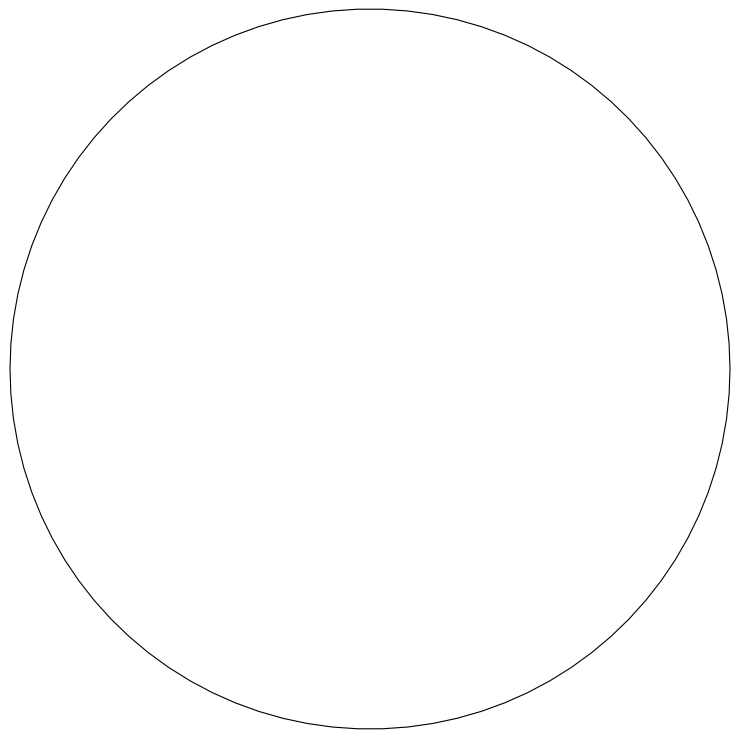

In [79]:
idx = 300
chosed_avhrr = AVHRR_info.loc[idx]
tle_name,border = chosed_avhrr.tle_name,chosed_avhrr.border 
IR,lons,lats = read_AVHRR(chosed_avhrr.filepath,tle_name)
proj =ccrs.NorthPolarStereo(central_longitude=0)
plt.rcParams['font.sans-serif'] = 'Times New Roman'
fig = plt.figure(figsize=(20,20))
ax0 = fig.add_axes([0,1.5, 0.362, 0.36],projection=proj)
urlinfo2fig(ax0,IR[:,:,4],lons,lats,lons.mean(),lats.mean(),border )

In [70]:
lons

array([[  18.67110909,   17.66983074,   16.61837901, ..., -131.82219906,
        -131.86955213, -131.91733351],
       [  18.9848051 ,   17.99349024,   16.95202948, ..., -131.90492652,
        -131.95158223, -131.9986589 ],
       [  19.30136747,   18.32022153,   17.28899131, ..., -131.9875701 ,
        -132.03354037, -132.07992717],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])

In [67]:
lons

array([[  18.67110909,   17.66983074,   16.61837901, ..., -131.82219906,
        -131.86955213, -131.91733351],
       [  18.9848051 ,   17.99349024,   16.95202948, ..., -131.90492652,
        -131.95158223, -131.9986589 ],
       [  19.30136747,   18.32022153,   17.28899131, ..., -131.9875701 ,
        -132.03354037, -132.07992717],
       [  19.61871457,   18.6477182 ,   17.62673063, ..., -132.07045372,
        -132.11576034, -132.16148008],
       [  19.9377882 ,   18.97702711,   17.96640566, ..., -132.15313556,
        -132.19771864, -132.2427052 ]])

In [38]:
lons

array([[  32.38043025,   31.93480102,   31.46005939, ..., -136.04113531,
        -136.05910111, -136.07722992],
       [  32.74586475,   32.3169243 ,   31.85983729, ..., -136.12449665,
        -136.14178837, -136.15924024],
       [  33.11365585,   32.70103388,   32.2613162 , ..., -136.20773501,
        -136.2242715 , -136.24095113],
       ...,
       [ 114.55333193,  115.18420631,  115.8015269 , ..., -179.39606839,
        -179.14747382, -178.89495928],
       [ 114.57229689,  115.2022314 ,  115.81862787, ..., -179.4467617 ,
        -179.19805456, -178.94542117],
       [ 114.59096553,  115.22002534,  115.83555178, ..., -179.49751083,
        -179.24872455, -178.99600954]])

d:\Anaconda\envs\FRZ\Lib\site-packages\pygac\calibration.py:198: RuntimeWarning: Using CoeffStatus.PROVISIONAL calibration coefficients
  warnings.warn(warning, RuntimeWarning)


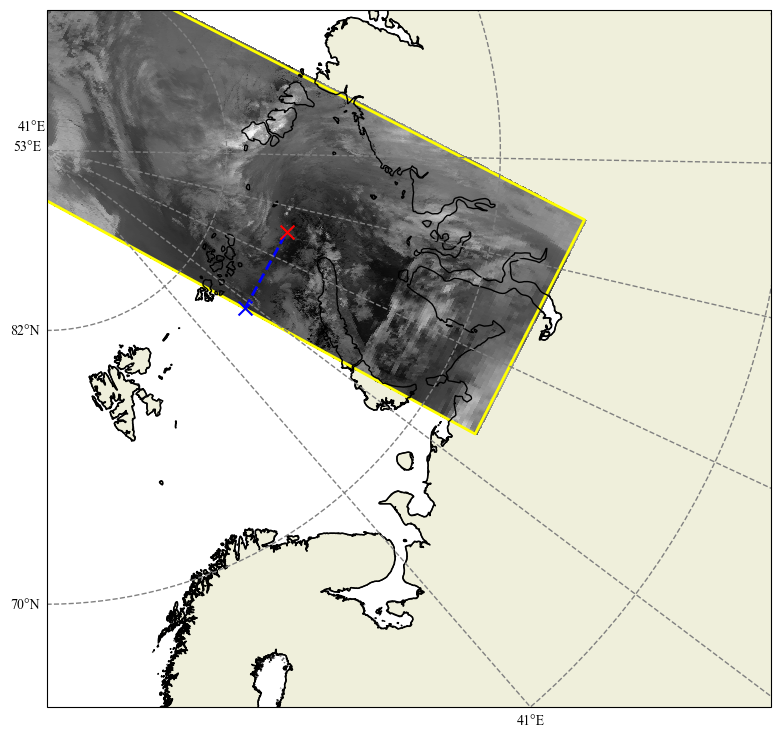

In [28]:
idx = 0
candidate_track = result.iloc[idx]
chosed_time,chosed_lon,chosed_lat,filepath = candidate_track.time,candidate_track.lon,candidate_track.lat,candidate_track.filepath
chosed_avhrr = AVHRR_info.loc[AVHRR_info.filepath==filepath].iloc[0]
tle_name,border = chosed_avhrr.tle_name,chosed_avhrr.border 
IR,lons,lats = read_AVHRR(filepath,tle_name)
near_lon,near_lat,inside,min_dis = nearest_judge(chosed_lon,chosed_lat,border)
proj =ccrs.NorthPolarStereo(central_longitude=0)
plt.rcParams['font.sans-serif'] = 'Times New Roman'
fig = plt.figure(figsize=(20,20))
ax0 = fig.add_axes([0,1.5, 0.362, 0.36],projection=proj)
urlinfo2fig(ax0,IR[:,:,4],lons,lats,chosed_lon,chosed_lat,border,near_lon,near_lat )